In [1]:
# 1. Use Pandas to repeat the Week 5 Exercise 5.7
# Hint1: Use pd.read_csv(url, ...) to read the USGS online gauge data.
# Hint2: Use df.set_index() to set the datetime column and df.resample() to calculate the monthly and annual statistics


import pandas as pd
import os

GageNumbers = ['06803495', '06803486']
Dates = ['2000-10-10', '2019-09-30']

def URL(GageList, Dates):
    gages = ('&site_no={}' * len(GageList)).format(*GageList)
    period = f'&period=&begin_date={Dates[0]}&end_date={Dates[1]}'
    return f'https://waterdata.usgs.gov/nwis/dv?&cb_00060=on&format=rdb{gages}&referred_module=sw{period}'

raw_df = pd.read_csv(URL(GageNumbers, Dates), skiprows=29, delimiter='\t', header=0, names=['Agency','Site','Date','Discharge_cfs','Qualification'])
raw_df.head(20)
raw_df.info()
df = raw_df[(raw_df['Agency']=='USGS')].copy()
df.head(20)

FlowFile = 'USGS_Stream_Flow_Data.csv'
df.to_csv(FlowFile, index=False)
df['Date']= pd.to_datetime(df['Date'])
df.info()
df = df.set_index(['Date'])
df['Discharge_cfs'] = pd.to_numeric(df['Discharge_cfs'], errors='coerce')

MonthlyStats = pd.DataFrame(columns=['Min','Max','Mean'])
MonthlyStats.Min = df.Discharge_cfs.groupby(df['Site']).resample('M').min()
MonthlyStats.Max = df.Discharge_cfs.groupby(df['Site']).resample('M').max()
MonthlyStats.Mean = df.Discharge_cfs.groupby(df['Site']).resample('M').mean()
MonthlyStats.head(20)
MonthFile = 'MonthlyFlowStats.csv'
MonthlyStats.to_csv(MonthFile, float_format='%.2f')
df['acreFeetPerDay'] = df['Discharge_cfs']*24*60*60/43560

AnnualTotal = pd.DataFrame(columns=['acreFeet'])
AnnualTotal.acreFeet = df.acreFeetPerDay.groupby(df['Site']).resample('A').sum()
AnnualTotal
AnnualFile = 'AnnualTotal.csv'
AnnualTotal.to_csv(AnnualFile, float_format='%.2f')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12315 entries, 0 to 12314
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Agency         12315 non-null  object
 1   Site           12306 non-null  object
 2   Date           12306 non-null  object
 3   Discharge_cfs  12306 non-null  object
 4   Qualification  12306 non-null  object
dtypes: object(5)
memory usage: 481.2+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12304 entries, 0 to 12314
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Agency         12304 non-null  object        
 1   Site           12304 non-null  object        
 2   Date           12304 non-null  datetime64[ns]
 3   Discharge_cfs  12304 non-null  object        
 4   Qualification  12304 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 576.8+ KB


     user_id  age gender     occupation zip_code
0          1   24      M     technician    85711
1          2   53      F          other    94043
2          3   23      M         writer    32067
3          4   24      M     technician    43537
4          5   33      F          other    15213
..       ...  ...    ...            ...      ...
938      939   26      F        student    33319
939      940   32      M  administrator    02215
940      941   20      M        student    97229
941      942   48      F      librarian    78209
942      943   22      M        student    77841

[943 rows x 5 columns]
                 s
occupation        
administrator   79
artist          28
doctor           7
educator        95
engineer        67
entertainment   18
executive       32
healthcare      16
homemaker        7
lawyer          12
librarian       51
marketing       26
none             9
other          105
programmer      66
retired         14
salesman        12
scientist       31
student 

AttributeError: 'Series' object has no attribute 'int'

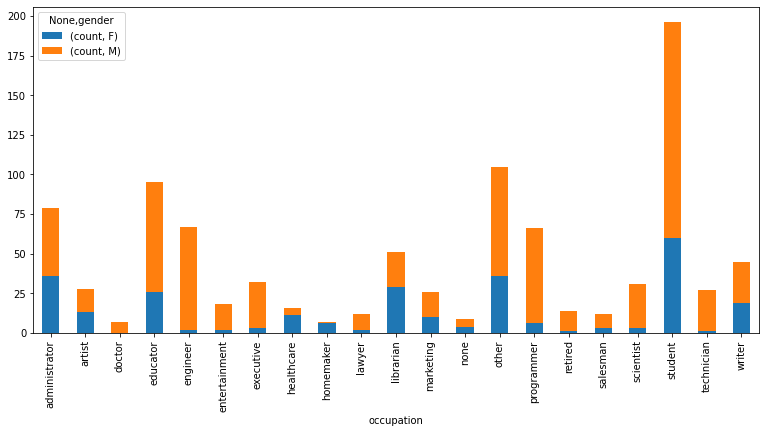

In [6]:
# 2. Use Pandas to
#     1.Read data in data/users.zip (using Pandas' the on-the-fly decompression cabability)

#     2.Identify all the occupations and compare the user numbers between STEM-related occupations and non-STEM occupations.

#     3.Identify the locations of the users that are programmers and above 35. How many male and female programmers, respectively? Is this ratio the same for the age under 35?

#     4.Compare the numbers of male and female for each occupations

#     5.Find the occupations with the youngest and oldest mean ages, respectively

#     6.Based on the first two digits of the zip codes, find the area with the largest number of users


import pandas as pd
import numpy as np
#####################################################################
#1
users=pd.read_csv('users.zip', sep='|')
print(users)
#####################################################################
#2
grouped_occ=users.groupby('occupation').occupation.agg(s=np.size)
print(grouped_occ)
STEM=grouped_occ.loc[['engineer','scientist', 'programmer', 'technician'],:]
print(STEM)
SumSTEM=sum(STEM['s'])
print(SumSTEM)
STEM_Percent=SumSTEM / len(users) *100
print(STEM_Percent, '% of users are STEM')
#####################################################################
#3
over35=users.groupby(['age', 'gender', 'zip_code']).age.agg(over_35=lambda x: (x>35).sum())
print(over35)
gender_over35=over35.groupby('gender').over_35.agg(old=np.sum)
print(gender_over35)
ratio_old=gender_over35['old'].values[0]/gender_over35['old'].values[1]
print('The Female to Male ratio for those over 35 is', "{:.2f}".format(ratio_old*100), '%')

under35=users.groupby(['age', 'gender', 'zip_code']).age.agg(under_35=lambda x: (x<=35).sum())
print(under35)
gender_under35=under35.groupby('gender').under_35.agg(young=np.sum)
print(gender_under35)
ratio_young=gender_under35['young'].values[0]/gender_under35['young'].values[1]
print('The Female to Male ratio for those under 35 is', "{:.2f}".format(ratio_young*100), '%')

#####################################################################
#4
occ_gender=users.pivot_table(values='age',index='occupation', columns='gender', aggfunc=['count'])
print(occ_gender)
occ_gender.plot.bar(figsize=(13,6), stacked=True)

#####################################################################
#5
mean_age_occ=users.groupby('occupation').age.agg(Mean=np.mean)
print(mean_age_occ)
maxi=mean_age_occ[mean_age_occ['Mean']==max(mean_age_occ['Mean'])]
print('The oldest:', maxi)
mini=mean_age_occ[mean_age_occ['Mean']==min(mean_age_occ['Mean'])]
print('The youngest:', mini)

#####################################################################
#6
largest_users=users.groupby(users.zip_code.int[:1])['zip_code'].sum()
print(largest_users)
#not finished... int doesn't work to split the zip value. 
# I cannot get this to work...

